In [1]:
import numpy as np
def chord_length_parameterization(D):
    t = np.zeros(len(D))
    for i in range(1, len(D)):
        t[i] = np.linalg.norm(D[i] - D[i-1])
    t = t.cumsum()
    t = t / t[-1]
    assert t[0] == 0 and t[-1] == 1
    return t

In [2]:
def insert_dummy(t, k):
    T = np.insert(t, 0, [0]*k)
    T = np.append(T, [1]*k)
    return T

In [4]:
def B(u, i, k, T):
    if k == 0:
        if T[i] <= u < T[i+1]:
            return 1.0
        else:
            return 0.0
    if T[i+k] == T[i]:
        c1 = 0.0
    else:
        c1 = (u - T[i]) / (T[i+k] - T[i]) * B(u, i, k-1, T)
    if T[i+k+1] == T[i+1]:
        c2 = 0.0
    else:
        c2 = (T[i+k+1] - u) / (T[i+k+1] - T[i+1]) * B(u, i+1, k-1, T)
    return c1+c2

In [5]:
def derivative(t, func, *args, **kwargs):
    dt = 1e-6
    dy = (func(t + dt, *args, **kwargs) - func(t, *args, **kwargs))
    return dy/dt
def second_derivative(t, func, *args, **kwargs):
    dt = 1e-6
    dy = derivative(t+dt, func, *args, **kwargs) - derivative(t, func, *args, **kwargs)
    return dy/dt

In [6]:
x = [0, 0, 2, 2, 4]
y = [0, 2, 2, 0, 0]
D = np.stack((x, y), axis=1)
k = 3
t =  chord_length_parameterization(D)
T = insert_dummy(t, k)

In [7]:
second_derivative(t[0], B, 0, 3, T)

95.99965267170774

In [8]:
second_derivative(t[0], B, 1, 3, T)

-143.99932800479576

In [9]:
second_derivative(t[0], B, 2, 3, T)

47.999648

In [10]:
n =len(D)-1

In [11]:
OFFSET = 1e-5
second_derivative(t[n]-OFFSET, B, n, 3, T)

47.99683200276103

In [12]:
second_derivative(t[n]-OFFSET, B, n+1, 3, T)

-143.99395200292986

In [13]:
second_derivative(t[n]-OFFSET, B, n+2, 3, T)

95.99665506954125

In [14]:
t

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [15]:
def get_N(k, t, T):
    n = len(t)-1
    N = np.zeros((n+3, n+3))
    for i in range(2, n+1):
        for j in range(i-1, i+2):
            N[i, j] = B(t[i-1], j, k, T)
            # print(f'N[{i}, {j}] = {N[i, j]}')
    N[0, 0] = 1.0
    N[n+2, n+2] = 1.0
    for i in range(0, 3):
        N[1, i] = second_derivative(t[0], B, i, k, T)
    for i in range(n, n+3):
        N[n+1, i] = second_derivative(t[n]-1e-5, B, i, k, T)
    return N

In [16]:
def get_D(x, y):
    D = np.stack((x, y), axis=1)
    D = np.insert(D, 1, [0, 0], axis=0)
    D = np.insert(D, len(D)-1, [0, 0], axis=0)
    return D

In [17]:
N = get_N(k, t, T)
print(N)

[[   1.            0.            0.            0.            0.
     0.            0.        ]
 [  95.99965267 -143.999328     47.999648      0.            0.
     0.            0.        ]
 [   0.            0.25          0.58333333    0.16666667    0.
     0.            0.        ]
 [   0.            0.            0.16666667    0.66666667    0.16666667
     0.            0.        ]
 [   0.            0.            0.            0.16666667    0.58333333
     0.25          0.        ]
 [   0.            0.            0.            0.           47.996832
  -143.993952     95.99665507]
 [   0.            0.            0.            0.            0.
     0.            1.        ]]


In [18]:
D = get_D(x, y)

In [25]:
from numpy.linalg import solve
P = solve(N, D)
print(P)

[[ 0.          0.        ]
 [-0.23809477  0.78571243]
 [-0.71428621  2.35714356]
 [ 2.85714387  2.5714289 ]
 [ 1.28571073 -0.64285915]
 [ 3.09524571 -0.21428124]
 [ 4.          0.        ]]


In [26]:
def bspline(u, P, k, T):
    n = len(T) - k -1
    assert (n >= k+1) and (len(P)>=n)
    return sum(P[i]*B(u, i, k, T) for i in range(n))

In [27]:
curve = np.array([bspline(x, P, 3, T) for x in np.arange(0, 1, 0.01)])

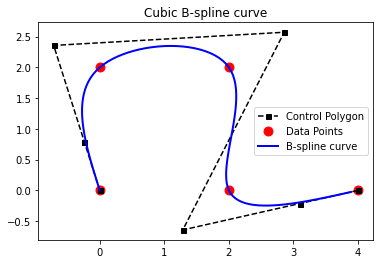

In [33]:
import matplotlib.pyplot as plt
plt.plot(P[:, 0], P[:, 1], '--k', label='Control Polygon', marker='s', markersize=5)
plt.scatter(x=x, y=y, c='r', s=80, label='Data Points')
plt.plot(curve[:, 0], curve[:, 1], 'b', linewidth=2, label='B-spline curve')
plt.legend()
plt.title('Cubic B-spline curve')
plt.show()